# Fixing Imbalanced Class

### Importing and Holdout set

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('songs_wdummies.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,track,artist,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,2,3,4,5,6,7,8,9,10,11
0,ROCKSTAR,DaBaby,0.746,0.690,-7.956,1,0.1640,0.24700,0.000000,0.1010,...,0,0,0,0,0,0,0,0,0,1
1,Savage Love,Jawsh 685,0.767,0.481,-8.520,0,0.0803,0.23400,0.000000,0.2690,...,0,0,0,0,0,0,0,0,0,0
2,Blinding Lights,The Weeknd,0.514,0.730,-5.934,1,0.0598,0.00146,0.000095,0.0897,...,0,0,0,0,0,0,0,0,0,0
3,Watermelon Sugar,Harry Styles,0.548,0.816,-4.209,1,0.0465,0.12200,0.000000,0.3350,...,0,0,0,0,0,0,0,0,0,0
4,Roses - Imanbek Remix,SAINt JHN,0.785,0.721,-5.457,1,0.0506,0.01490,0.004320,0.2850,...,0,0,0,0,0,0,1,0,0,0


In [3]:
entire_X = df.drop(['track', 'artist', 'top100', 'top10'], axis=1)
entire_y = df['top100']

X, X_test, y, y_test = train_test_split(entire_X, entire_y, random_state=111, test_size=.2)

print('Proporiton of 0 class = ', 1 - y.mean())
print('Proporiton of 1 class = ', y.mean())

Proporiton of 0 class =  0.897742363877822
Proporiton of 1 class =  0.10225763612217796


### Base Model

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from model_selection import classification_scores_cv as score
from model_selection import show_importance_cv
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [6]:
def get_all_scores(X, y, sample=None, weight=None):
    all_model_scores = {
        'Logistic_Regression': score(X, y, model_idx=0, sample=sample, weight=weight),
        'SVM': score(X, y, model_idx=1, sample=sample, weight=weight),
        'Random Forest': score(X, y, model_idx=2, sample=sample, weight=weight),
        'KNN': score(X, y, model_idx=3, sample=sample, weight=weight),
        'Naive Bayes': score(X, y, model_idx=4, sample=sample, weight=weight)
    }

    for model in all_model_scores:
        print(f"\n{model}")
        for metric in all_model_scores[model]:
            print(f"{metric} score - " +\
                  f"{all_model_scores[model][metric][0]}" +\
                  f" overfitting by: {all_model_scores[model][metric][1]}")

In [7]:
get_all_scores(X, y) # Cant fix the overfitting with Random Forrest


Logistic_Regression
accuracy score - 0.902 overfitting by: 0.0
precision score - 0.547 overfitting by: 0.18
recall score - 0.233 overfitting by: 0.09
F-Beta score - 0.426 overfitting by: 0.15
ROC/AUC score - 0.781 overfitting by: 0.1

SVM
accuracy score - 0.898 overfitting by: 0.0
precision score - 0.0 overfitting by: 1.0
recall score - 0.0 overfitting by: 0.14
F-Beta score - 0.0 overfitting by: 0.43
ROC/AUC score - 0.787 overfitting by: 0.19

Random Forest
accuracy score - 0.91 overfitting by: 0.0
precision score - 0.893 overfitting by: 0.11
recall score - 0.143 overfitting by: 0.54
F-Beta score - 0.398 overfitting by: 0.52
ROC/AUC score - 0.868 overfitting by: 0.13

KNN
accuracy score - 0.898 overfitting by: 0.0
precision score - 0.0 overfitting by: 0.4
recall score - 0.0 overfitting by: 0.01
F-Beta score - 0.0 overfitting by: 0.04
ROC/AUC score - 0.686 overfitting by: 0.2

Naive Bayes
accuracy score - 0.694 overfitting by: 0.0
precision score - 0.235 overfitting by: 0.08
recall sco

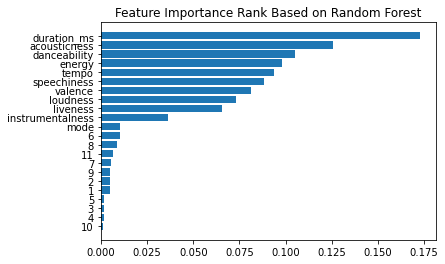

In [8]:
show_importance_cv(X, y)

Logistic Regression and Random Forest are doing the best. I'll stick to those two moving foreward

.43 F1 -- Logistic Regression

.86 Precision - Random Forest (A bit more emphasis on this over Recall)

.85 AUC - Random Forest

Random Forest may be a bit better, but its tremendously over fitting.

In [9]:
def get_scores(X, y, sample=None, weight=None):
    all_model_scores = {
        'Logistic_Regression': score(X, y, model_idx=0, sample=sample, weight=weight),
        'Random Forest': score(X, y, model_idx=2, sample=sample, weight=weight),
#         'XGBoost': score(X, y, model_idx=5, sample=sample, weight=weight)
    }

    for model in all_model_scores:
        print(f"\n{model}")
        for metric in all_model_scores[model]:
            print(f"{metric} score - " +\
                  f"{all_model_scores[model][metric][0]}" +\
                  f" overfitting by: {all_model_scores[model][metric][1]}")

## Feature Engineering 

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from model_selection import show_importance_cv

In [11]:
X_adjuster = X.copy()
X_adjuster.columns

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
      dtype='object')

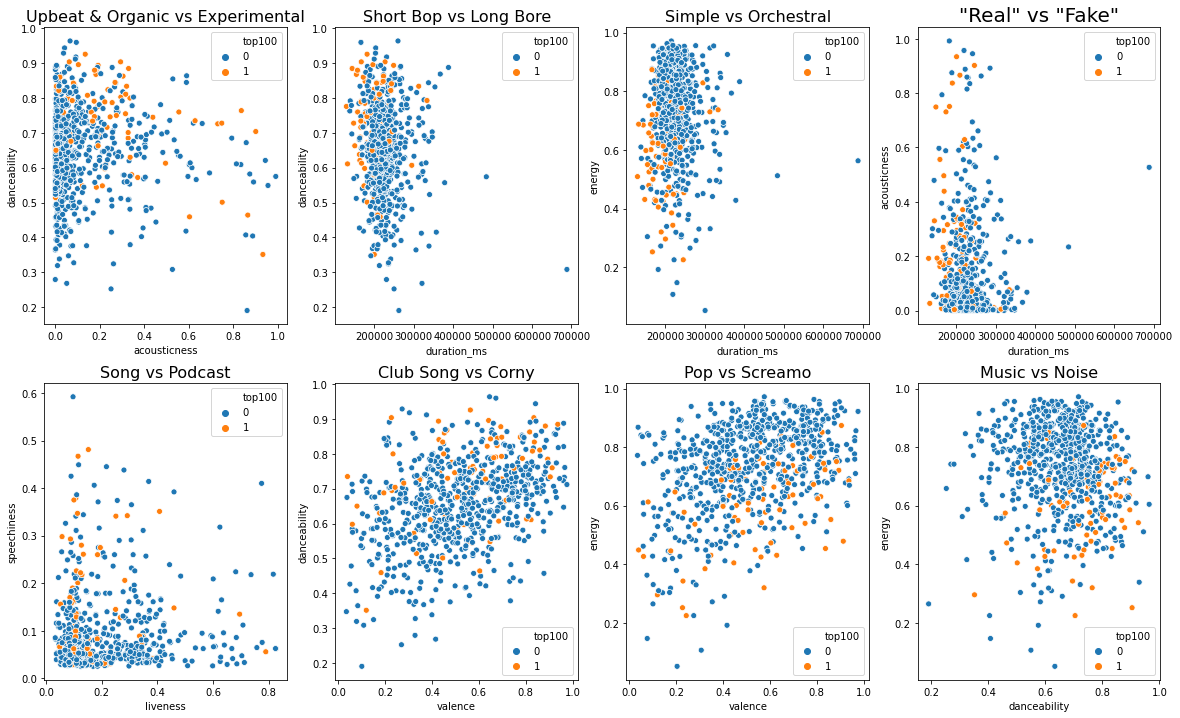

In [12]:
combined = pd.concat([X, y], axis=1)

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

''' These first 4 are based on the pair plot from the previous notebook'''

# Plot 1 (multiply)
sns.scatterplot('acousticness', 'danceability', data=combined, hue='top100', ax=ax1)
ax1.set_title('Upbeat & Organic vs Experimental', fontsize=16)
# Plot 2 (divide)
sns.scatterplot('duration_ms', 'danceability', data=combined, hue='top100', ax=ax2)
ax2.set_title('Short Bop vs Long Bore', fontsize=16)
# Plot 3 (multiply)
sns.scatterplot('duration_ms', 'energy', data=combined, hue='top100', ax=ax3)
ax3.set_title('Simple vs Orchestral', fontsize=16)
# Plot 4 (divide)
sns.scatterplot('duration_ms', 'acousticness', data=combined, hue='top100', ax=ax4)
ax4.set_title('"Real" vs "Fake"', fontsize=20)


'''These next 4 are based on intuiton'''

# Plot 5
sns.scatterplot('liveness', 'speechiness', data=combined, hue='top100', ax=ax5)
ax5.set_title('Song vs Podcast', fontsize=16)
# Plot 6
sns.scatterplot('valence', 'danceability', data=combined, hue='top100', ax=ax6)
ax6.set_title('Club Song vs Corny', fontsize=16)
# Plot 7
sns.scatterplot('valence', 'energy', data=combined, hue='top100', ax=ax7)
ax7.set_title('Pop vs Screamo', fontsize=16)
# Plot 8
sns.scatterplot('danceability', 'energy', data=combined, hue='top100', ax=ax8)
ax8.set_title('Music vs Noise', fontsize=16)


plt.show();

In [13]:
X_adjuster['Acoustic*Dance'] = X_adjuster['acousticness']*X_adjuster['danceability']
X_adjuster['Duration/Dance'] = X_adjuster['duration_ms']/(X_adjuster['danceability']+1)
X_adjuster['Duration*Energy'] = X_adjuster['duration_ms']*X_adjuster['energy']
X_adjuster['Duration/Acoustic'] = X_adjuster['duration_ms']/(X_adjuster['acousticness']+1)
X_adjuster['Live*Speech'] = X_adjuster['liveness']*X_adjuster['speechiness']
X_adjuster['Valence/Dance'] = X_adjuster['valence']/(X_adjuster['danceability']+1)
X_adjuster['Valence/Energy'] = X_adjuster['valence']/(X_adjuster['energy']+1)
X_adjuster['Dance/Energy'] = X_adjuster['danceability']/(X_adjuster['energy']+1)

In [14]:
get_scores(X_adjuster, y)


Logistic_Regression
accuracy score - 0.9 overfitting by: 0.0
precision score - 0.526 overfitting by: 0.2
recall score - 0.247 overfitting by: 0.08
F-Beta score - 0.423 overfitting by: 0.16
ROC/AUC score - 0.776 overfitting by: 0.11

Random Forest
accuracy score - 0.907 overfitting by: 0.0
precision score - 0.636 overfitting by: 0.36
recall score - 0.183 overfitting by: 0.6
F-Beta score - 0.408 overfitting by: 0.54
ROC/AUC score - 0.848 overfitting by: 0.15


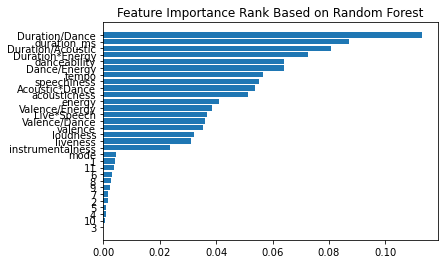

In [15]:
show_importance_cv(X_adjuster, y)

Good to see some of the engineered features at the top of the feature importance

## Resampling Techniques

After trying Oversampling, Undersampling, and SMOTE, oversampling did the best!? My assumption is that because the data is so spread out, SMOTE and undersampling just blurred the lines between a top 100 and not.

Note: sample takes in a touple of 1. an index 0(oversample), 1(undersample) or 2(smote) and 2. a touple of the weight distribution.

In [16]:
# Oversampling : 4 times the minority
get_scores(X_adjuster, y, sample=(0, (3, 1)))


Logistic_Regression
accuracy score - 0.858 overfitting by: 0.0
precision score - 0.344 overfitting by: 0.41
recall score - 0.469 overfitting by: 0.15
F-Beta score - 0.362 overfitting by: 0.36
ROC/AUC score - 0.769 overfitting by: 0.13

Random Forest
accuracy score - 0.9 overfitting by: 0.0
precision score - 0.514 overfitting by: 0.48
recall score - 0.354 overfitting by: 0.64
F-Beta score - 0.461 overfitting by: 0.54
ROC/AUC score - 0.837 overfitting by: 0.16


F beta went up, but AUC went down for Random Forest. Logistic Regression went down overall. I don't think resampling is a good idea.

##  Adjusting Class Weights

In [17]:
get_scores(X, y, weight=(9, 1))


Logistic_Regression
accuracy score - 0.902 overfitting by: 0.0
precision score - 0.547 overfitting by: 0.17
recall score - 0.233 overfitting by: 0.09
F-Beta score - 0.426 overfitting by: 0.15
ROC/AUC score - 0.781 overfitting by: 0.1

Random Forest
accuracy score - 0.907 overfitting by: 0.0
precision score - 0.867 overfitting by: 0.13
recall score - 0.131 overfitting by: 0.55
F-Beta score - 0.363 overfitting by: 0.55
ROC/AUC score - 0.862 overfitting by: 0.14


Logistic Regression stayed the same as the baseline model

## Preprocessing - Putting it all together

Best Model: Random Forest

Contrary, to what I found above, they parameters below result in the best FBeta score and AUC score. 

In [18]:
# Best  
#RandomForestClassifier(class_weight=weight, min_samples_leaf=2, n_estimators=1000)
"""
    Random Tree forest
- Weight: minority twice as important
- SMOTE: Double the minority samples
- 1000 trees to choose from
- 2 minimum leaf samples

Note: the numbers here are different from the trials above,
    but the trials were used as a refference starting point.

"""


# model_score2 = score(X_adjuster, y, model_idx=2, weight=(2, 1), sample=(2, (2, 1)))
# print('Random Forest')
# model_score2
get_scores(X_adjuster, y, weight=(2, 1), sample=(2, (2, 1)))


Logistic_Regression
accuracy score - 0.899 overfitting by: 0.0
precision score - 0.507 overfitting by: 0.3
recall score - 0.232 overfitting by: 0.07
F-Beta score - 0.405 overfitting by: 0.2
ROC/AUC score - 0.77 overfitting by: 0.13

Random Forest
accuracy score - 0.911 overfitting by: 0.0
precision score - 0.619 overfitting by: 0.38
recall score - 0.368 overfitting by: 0.53
F-Beta score - 0.53 overfitting by: 0.45
ROC/AUC score - 0.84 overfitting by: 0.16


Overall, in Random Forest, the F-Beta score increased tremendously from 0 to .358 to .52, and the accuracy went up a little while the AUC stayed about the same. 

### Threshold Adjustment

In [19]:
from model_selection import get_threshold

Split 1: Best F-Beta score 0.484 at prob decision threshold >= 0.283
Split 2: Best F-Beta score 0.278 at prob decision threshold >= 0.204
Split 3: Best F-Beta score 0.481 at prob decision threshold >= 0.139
Split 4: Best F-Beta score 0.323 at prob decision threshold >= 0.268
Split 5: Best F-Beta score 0.146 at prob decision threshold >= 0.196
Mean F-Beta 0.342 at prob decision threshold >= 0.218


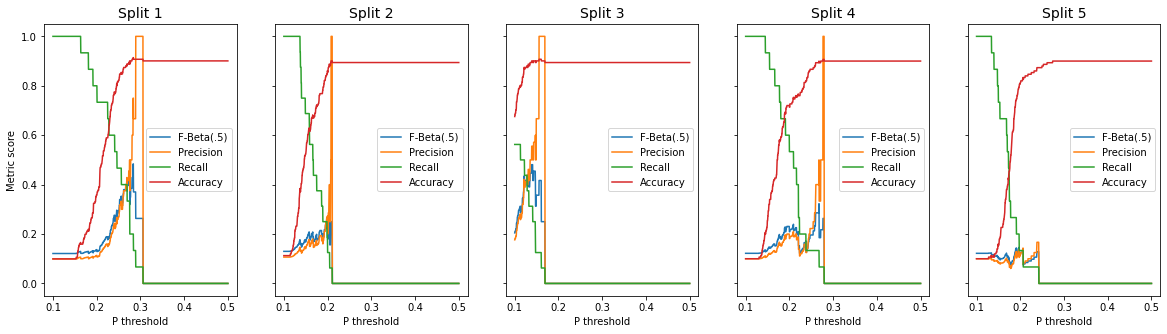

In [20]:
get_threshold(X_adjuster, y, model_idx=2, weight=(2, 1), sample=(2, (2, 1)))

## Putting it all together - Final Model

In [21]:
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier   #, GradientBoostingClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score, roc_auc_score

In [22]:
'''Feature Engineering'''

X_test_adjusted = X_test.copy()

X_test_adjusted['Acoustic*Dance'] = X_test_adjusted['acousticness']*X_test_adjusted['danceability']
X_test_adjusted['Duration/Dance'] = X_test_adjusted['duration_ms']/(X_test_adjusted['danceability']+1)
X_test_adjusted['Duration*Energy'] = X_test_adjusted['duration_ms']*X_test_adjusted['energy']
X_test_adjusted['Duration/Acoustic'] = X_test_adjusted['duration_ms']/(X_test_adjusted['acousticness']+1)
X_test_adjusted['Live*Speech'] = X_test_adjusted['liveness']*X_test_adjusted['speechiness']
X_test_adjusted['Valence/Dance'] = X_test_adjusted['valence']/(X_test_adjusted['danceability']+1)
X_test_adjusted['Valence/Energy'] = X_test_adjusted['valence']/(X_test_adjusted['energy']+1)
X_test_adjusted['Dance/Energy'] = X_test_adjusted['danceability']/(X_test_adjusted['energy']+1)

In [23]:
'''Creating the Model'''

X_tr, y_tr = np.array(X_adjuster), np.array(y)
X_te, y_te = np.array(X_test_adjusted), np.array(y_test)

# No need to scale for Random Forest

n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)

smote_ratio = {1: n_pos * 2, 0: n_neg}
weight_ratio = {1: n_pos * 2, 0: n_neg}

sampler = SMOTE(sampling_strategy=smote_ratio, random_state=42)
X_tr_smote, y_tr_smote = sampler.fit_sample(X_tr, y_tr)

model = RandomForestClassifier(class_weight=weight_ratio, min_samples_leaf=2, n_estimators=1000)

model.fit(X_tr_smote, y_tr_smote)

RandomForestClassifier(class_weight={0: 676, 1: 154}, min_samples_leaf=2,
                       n_estimators=1000)

In [24]:
# Predicted y's with the threshold at .219
predicted_ys = model.predict_proba(X_te)[:,1] >= 0.219

# Metrics
print("F-Beta Score = {0:.3f}".format(fbeta_score(y_te, predicted_ys, beta=.5, zero_division=0)))
print("Precision = {0:.3f}".format(precision_score(y_te, predicted_ys, zero_division=0)))
print("Recall = {0:.3f}".format(recall_score(y_te, predicted_ys, zero_division=0)))
print("ROC/AUC = {0:.3f}".format(roc_auc_score(y_te, model.predict_proba(X_te)[:, 1])))

F1 Beta Score = 0.367
Precision = 0.333
Recall = 0.619
ROC/AUC = 0.764


In [25]:
feature_importances = {}
weights = model.feature_importances_

for idx, column in enumerate(X_adjuster.columns):
    feature_importances[column] = weights[idx]

ft_imp_dict = pd.DataFrame.from_dict(feature_importances, orient='index').reset_index()
ft_imp_dict.rename({'index':'category', 0:'weight'}, axis=1, inplace=True)
ft_imp_dict.sort_values(by='weight', inplace=True, ignore_index=True)

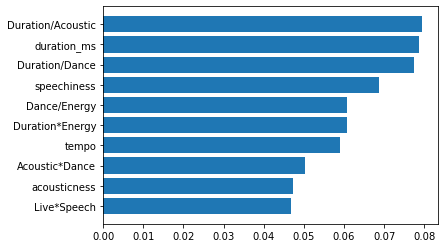

In [26]:
plt.barh(ft_imp_dict.tail(10).iloc[:,0], ft_imp_dict.tail(10).iloc[:,1]);

## Pickling the Model

In [27]:
import pickle

pickle.dump(model, open("song_model.pkl", "wb"))

In [28]:
!ls

Affair_Predictor.ipynb         challenge_set_7_emmanuel.ipynb
Classwork_nonsense             challenge_set_8_emmanuel.ipynb
Instagram_Scrape_Fail.ipynb    decade_hits.csv
Metis_2020_Submissions         decade_hits.pickle
Metis_Files                    exercise
Project2_BGG                   gitHub_blog
Spotify1_Scraping.ipynb        model_selection.py
Spotify2_EDA_MVP.ipynb         song_model.pkl
Spotify3_Model_Tuning.ipynb    songs_wdummies.csv
Stats_Prework                  top_100.csv
WebScrape                      top_100.pickle
__pycache__


In [55]:
# Predicted y's with the threshold at .219
predicted_ys = model.predict_proba(X_te)[:,1] >= 0.485

# Metrics
print("F1 Beta Score = {0:.3f}".format(fbeta_score(y_te, predicted_ys, beta=.5, zero_division=0)))
print("Precision = {0:.3f}".format(precision_score(y_te, predicted_ys, zero_division=0)))
print("Recall = {0:.3f}".format(recall_score(y_te, predicted_ys, zero_division=0)))
print("ROC/AUC = {0:.3f}".format(roc_auc_score(y_te, model.predict_proba(X_te)[:, 1])))

F1 Beta Score = 0.510
Precision = 0.714
Recall = 0.238
ROC/AUC = 0.764


In [52]:
# precisions = []
# for i in np.arange(.1, .5, .001):
#     predicted_ys = model.predict_proba(X_te)[:,1] >= i
#     precisions.append(precision_score(y_te, predicted_ys, zero_division=0))
# max_prec = max(precisions)
index_max = precisions.index(max_prec) * .001 + .1

print(f"Max precision {max_prec} at threshold {index_max}")

Max precision 0.7142857142857143 at threshold 0.485
